In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

# Source Image

Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)

beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }
gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros

def get_source(dx, dy, dI):
    settings = toliman_settings.copy()
    settings['tilt_x'] = dx
    settings['tilt_y'] = dy
    new  = {
            'wavelengths': [wavelength],
            'weights': [dI],
            'settings': settings
            }
    return new

params_a = (-1,-0.5,1.3) # Chosen at random
params_b = (params_a[0],params_a[1]+5.,params_a[2]/3.)

In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
# First source, on axis
# Second source, offset 5" and fainter
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [get_source(params_a[0],params_a[1],params_a[2]), get_source(params_b[0],params_b[1],params_b[2])], gridsize, detector_pitch, npixels)

/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [4]:
import numpy as np
src_peak_photons = 25000
src_intensity_scale = (src_peak_photons/raw_image.max(axis=None))
raw_image = np.clip(src_intensity_scale*raw_image,0.,None)
detector_image = np.random.poisson(raw_image)

# Fitting

## Create a dual PSF and check fitting error


In [5]:
# Calculated PSF using on-axis image
from proper_tools import form_detector_image, form_multi_psf, fix_prop_pixellate

In [6]:
test_flux = 1.0
#print('Flux based upon observed peak = {}'.format(test_flux))
test_offset = (0.,0.)
#print('Test PSF centred at ({},{})'.format(test_offset[0],test_offset[1]))
      
common_sampling = detector_pitch/2. # for Nyquist
npsf = npixels*2
#print('Generating PSF with sampling {} and size {}'.format(common_sampling,npsf))
psf_ref = form_multi_psf('prescription_rc_quad', [get_source(test_offset[0],test_offset[1],test_flux)], gridsize, common_sampling, npsf)


In [7]:
def image_err(im):
    diff = im - detector_image
    return np.sum((diff)**2)
    
min_err = image_err(raw_image)

In [10]:
f_eff = 15. # metres
as_to_m = f_eff * np.pi / (3600 * 180) #m/as

model = {}
model['x'] = [0.,0.,0.,0.,0.,0.]
model['psf_a_pix'] = np.zeros_like(detector_image)
model['psf_b_pix'] = np.zeros_like(detector_image)

def model_image():
    return (model['psf_a_pix']*model['x'][2] + model['psf_b_pix']*model['x'][5]) * src_intensity_scale

def set_psf_a(im):
    model['psf_a_pix'] = im

def set_pos_a(dx,dy):
    x = model['x']
    x[0] = dx
    x[1] = dy
    set_psf_a(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(dx*as_to_m,dy*as_to_m)))

def set_psf_b(im):
    model['psf_b_pix'] = im
    
def set_pos_b(dx,dy):
    x = model['x']
    x[3] = dx
    x[4] = dy
    set_psf_b(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(dx*as_to_m,dy*as_to_m)))

def set_major_flux(f):
    x = model['x']
    x[2] = f

def set_minor_flux(f):
    x = model['x']
    x[5] = f
    
def update_err(printerr=False, logerr=True):
    x = model['x']
    tiltx1 = x[0]
    tilty1 = x[1]    
    flux1 = x[2]
    tiltx2 = x[3]
    tilty2 = x[4]
    flux2 = x[5]
    err = image_err(model_image())
    if logerr is True:
        errors.append((x.copy(),err))
    if printerr is True:
        print('Error for offsets ({:.2e},{:.2e}),({:.2e},{:.2e}) and fluxes {:.2e},{:.2e}: {}% baseline '.format(tiltx1, tiltx1, tiltx2, tiltx2, flux1, flux2, round(100.*err/min_err)))
    return err

def model_err_major_pos(params, printerr=False, logerr=True):
    set_pos_a(params[0],params[1])
    return update_err(printerr, logerr)

def model_err_minor_pos(params, printerr=False, logerr=True):
    set_pos_b(params[0],params[1])
    return update_err(printerr,logerr)

def model_err_major_flux(f, printerr=False, logerr=True):
    set_major_flux(f)
    return update_err(printerr,logerr)

def model_err_minor_flux(f, printerr=False, logerr=True):
    set_minor_flux(f)
    return update_err(printerr,logerr)


In [11]:
print('Minimum error (original - noisy) = {}'.format(min_err))

Minimum error (original - noisy) = 24592754.281664282


## Step 1: major source position

Want to find the best location for the first star, and for the time being will assume that the problem is independent of the effects of the second star. Assume also that the peak signal in the image is solely due to the peak of the major source (i.e. minor source is weak and far away from the major source, and noise is negligible), and so set a working figure for the major flux accordingly. Could optionally scale this by a fudge factor. We will tweak this later on.

In [12]:
model['x'] = [0.,0.,0.,0.,0.,0.]
est_flux = detector_image.max(axis=None)*1. / src_peak_photons
model['x'][2] = est_flux
print(model['x'])

[0.0, 0.0, 0.99412, 0.0, 0.0, 0.0]


How does the landscape look? Here I'm plotting the error function at reaonably high resolution, but ideally an optimiser will not explore this by such brute force means.

In [13]:
import numpy as np
errors = []
ds = np.linspace(-10, 10, 51)
X,Y  = np.meshgrid(ds,ds)
Z = np.empty_like(X)
for i in range(len(ds)):
    for j in range(len(ds)):
        Z[i][j] = model_err_major_pos([X[i][j],Y[i][j]], printerr=False,logerr=False)

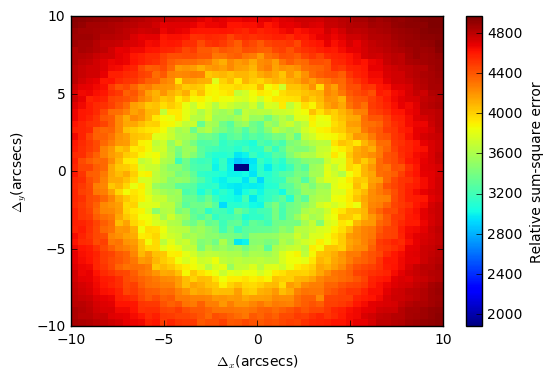

In [27]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)#,
#                       norm=LogNorm(vmin=fx.min(), 
#                                    vmax=fx.max()))
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
plt.show()

How does the optimizer do in finding the minimum?

In [23]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = gp_minimize(model_err_major_pos, params_init)

/usr/physics/python/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


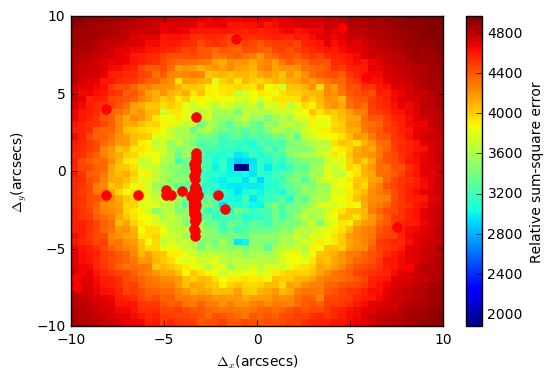

In [28]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.legend(loc="best", numpoints=1)
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")

tested = [(x,y) for ((x,y,_,_,_,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"rx", markersize=14, lw=0)

plt.show()


In [29]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = gp_minimize(model_err_major_pos, params_init, x0=[0.,0.], n_random_starts=10)

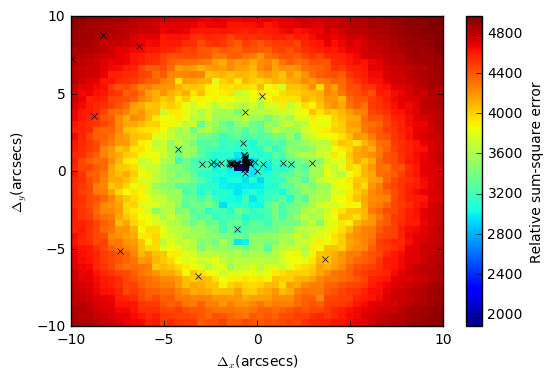

In [31]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")

tested = [(x,y) for ((x,y,_,_,_,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=5, lw=0, label="Tested")

plt.show()

In [32]:
print(res.x)

[-1.0886886559109055, -0.4774754298445778]


In [33]:
import numpy as np
x_fine_init = res.x
ds = np.linspace(-0.5, .5, 21)
Xfine,Yfine  = np.meshgrid(ds+x_fine_init[0],ds+x_fine_init[1])
Zfine = np.empty_like(Xfine)
for i in range(len(ds)):
    for j in range(len(ds)):
        Zfine[i][j] = model_err_major_pos([Xfine[i][j],Yfine[i][j]], printerr=False,logerr=False)

In [34]:
from skopt import gp_minimize
errors=[]
params_init = [(-0.5+x_fine_init[0],0.5+x_fine_init[0]),(-0.5+x_fine_init[1],0.5+x_fine_init[1])]
res = gp_minimize(model_err_major_pos, params_init, x0=x_fine_init, n_random_starts=10)

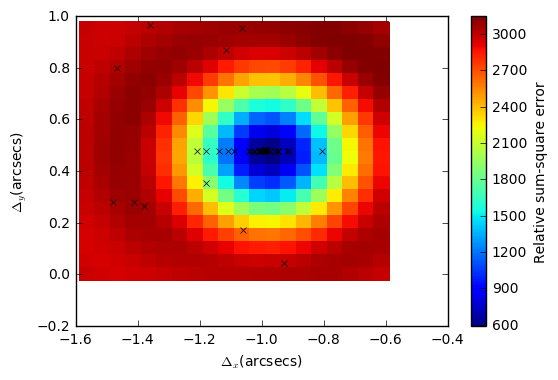

In [35]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(Xfine, -Yfine, Zfine / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
#ax.legend(loc="best", numpoints=1)
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")

tested = [(x,y) for ((x,y,_,_,_,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=5, lw=0, label="Tested")

plt.show()

In [36]:
print(res.x)

[-0.99842820481282679, -0.47819795092495965]


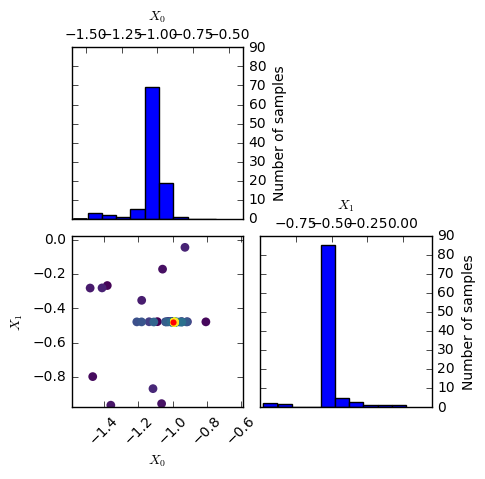

In [40]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(res, bins=10)
plt.show()

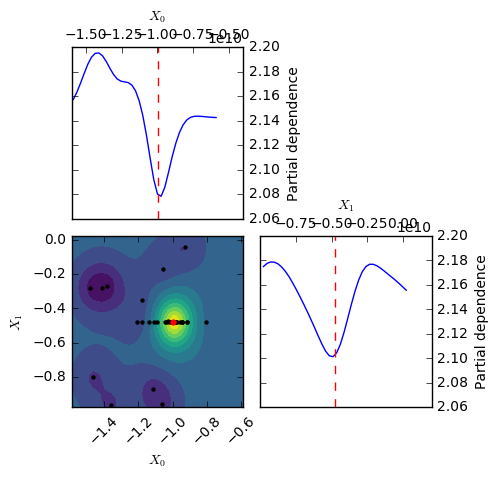

In [43]:
from skopt.plots import plot_objective

_ = plot_objective(res)
plt.show()

In [44]:
xmin = res.x
set_pos_a(xmin[0],xmin[1])

##  Step 2: major source flux

/usr/physics/python/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


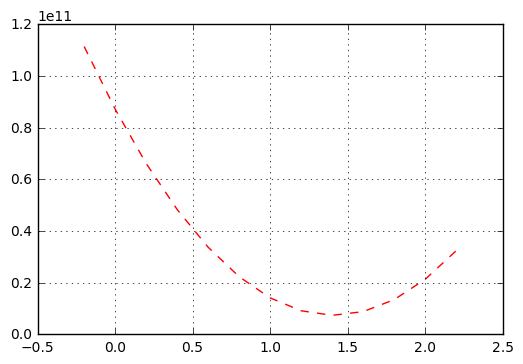

In [50]:
# Plot f(x) + contours
x = np.arange(-0.2, 2.2, .2).reshape(-1, 1)
fx = [model_err_major_flux(x_i,printerr=False, logerr=False) for x_i in x]
plt.plot(x, fx, "r--")#, label="True (unknown)")
plt.legend()
plt.grid()
plt.show()

In [51]:
from skopt import gp_minimize
errors=[]
params_init = [(0.2,2.)]
res = gp_minimize(model_err_major_flux, params_init, x0=[est_flux])

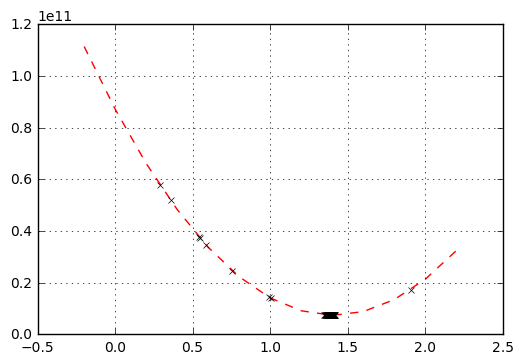

In [55]:
plt.plot(x, fx, "r--")#, label="True (unknown)")
tested = [(v,e) for ((_,_,v,_,_,_),e) in errors]
plt.plot([v for (v,e) in tested], [e for (v,e) in tested],"kx", markersize=5, lw=0, label="Tested")
#plt.legend()
plt.grid()
plt.show()


In [56]:
print(res.x)
set_major_flux(res.x[0])

[1.410691195676399]


## Step 3: minor source position

In [57]:
residual = detector_image - model_image()

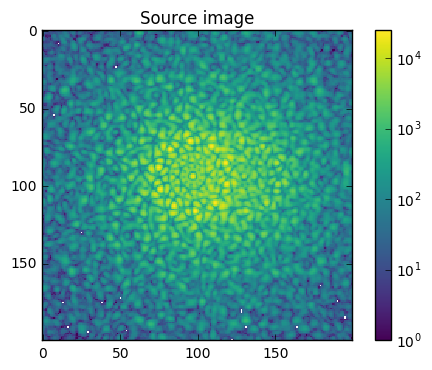

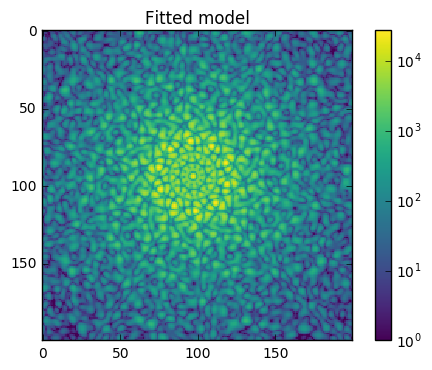

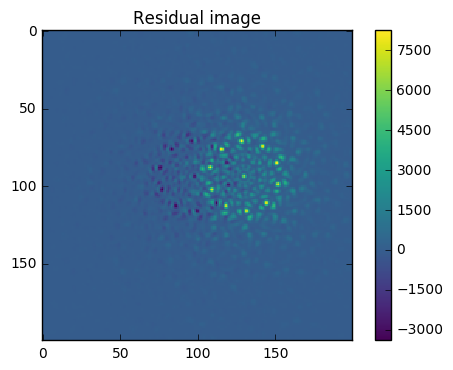

In [59]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(detector_image[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Source image')
plt.show()

plt.imshow(model_image()[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Fitted model')
plt.show()

plt.imshow(residual[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Residual image')
plt.show()

In [60]:
est_flux = residual.max(axis=None)*1. / src_peak_photons
print('Flux based upon observed peak = {}'.format(est_flux))
set_minor_flux(est_flux)

Flux based upon observed peak = 0.3301139494289303


In [61]:
import numpy as np
errors = []
ds = np.linspace(-10, 10, 51)
X,Y  = np.meshgrid(ds,ds)
Z = np.empty_like(X)
for i in range(len(ds)):
    for j in range(len(ds)):
        Z[i][j] = model_err_minor_pos([X[i][j],Y[i][j]], printerr=False,logerr=False)

In [62]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = gp_minimize(model_err_minor_pos, params_init, x0=[0.,0.], n_random_starts=10)

/usr/physics/python/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


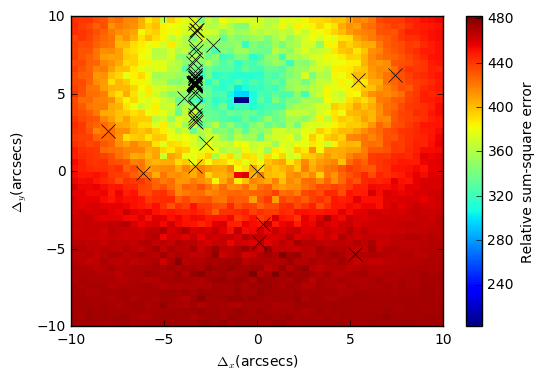

In [74]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.legend(loc="best", numpoints=1)
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)

plt.show()


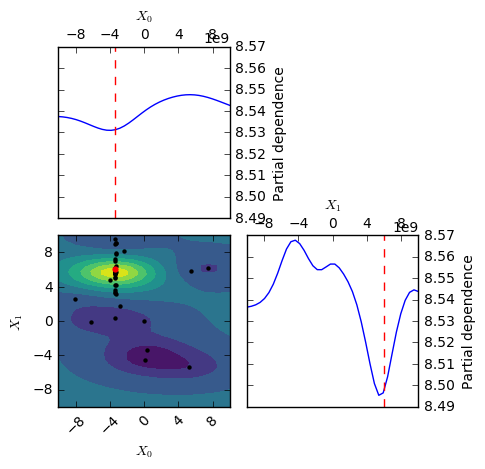

In [67]:
from skopt.plots import plot_objective

_ = plot_objective(res)
plt.show()

This did a pretty rubbish job of converging on the right location. Perhaps improve with more sampling.

In [75]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = gp_minimize(model_err_minor_pos, params_init, x0=[0.,0.], n_random_starts=20)

/usr/physics/python/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


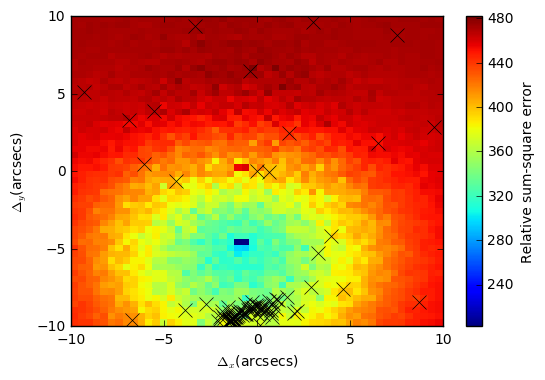

In [76]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)

plt.show()


In [77]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = gp_minimize(model_err_minor_pos, params_init, x0=[0.,0.], n_random_starts=30)

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)

plt.show()


In [79]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = gp_minimize(model_err_minor_pos, params_init, x0=[0.,0.], n_random_starts=50)

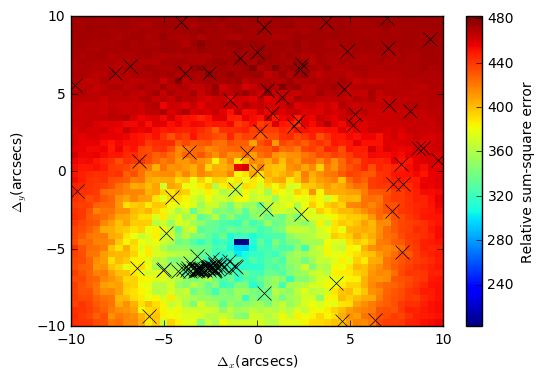

In [80]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)

plt.show()


What about specifying a set of specific test points across a uniform grid?

In [81]:
from skopt import gp_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
ds = np.linspace(-9, 9, 5)
testpoints = [(x,y) for x in ds for y in ds]
res = gp_minimize(model_err_minor_pos, params_init, x0=testpoints, n_random_starts=0)

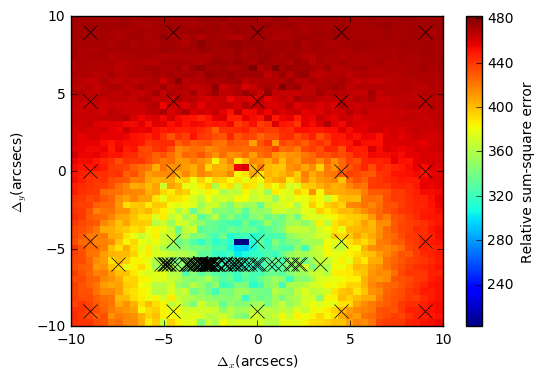

In [82]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)

plt.show()


In [84]:
from skopt import forest_minimize
errors=[]
params_init = [(-10.,10.),(-10.,10.)]
res = forest_minimize(model_err_minor_pos, params_init)

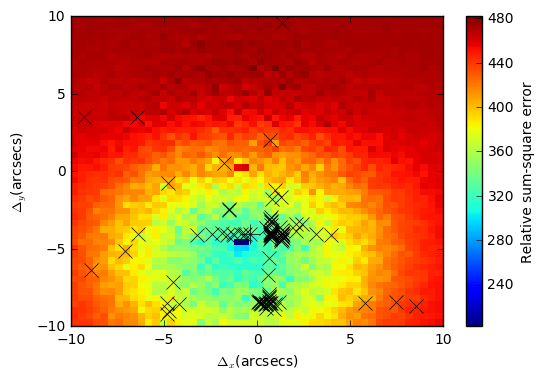

In [86]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(X, -Y, Z / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)
ax.plot(res.x[0], -res.x[1],"k+", markersize=14)
plt.show()


In [92]:
print(params_a)

(-1, -0.5, 1.3)


In [90]:
print(params_b)

(-1, 4.5, 0.43333333333333335)


In [95]:
set_major_flux(1.410691195676399)
set_pos_a(-0.99842820481282679, -0.47819795092495965)

In [96]:
print(model['x'])

[-0.9984282048128268, -0.47819795092495965, 1.410691195676399, -1.8976252068229602, 3.9685533746368833, 0.3301139494289303]


In [97]:
import numpy as np
x_fine_init = res.x
ds = np.linspace(-0.5, .5, 21)
Xfine,Yfine  = np.meshgrid(ds+params_b[0],ds+params_b[1])
Zfine = np.empty_like(Xfine)
for i in range(len(ds)):
    for j in range(len(ds)):
        Zfine[i][j] = model_err_minor_pos([Xfine[i][j],Yfine[i][j]], printerr=False,logerr=False)

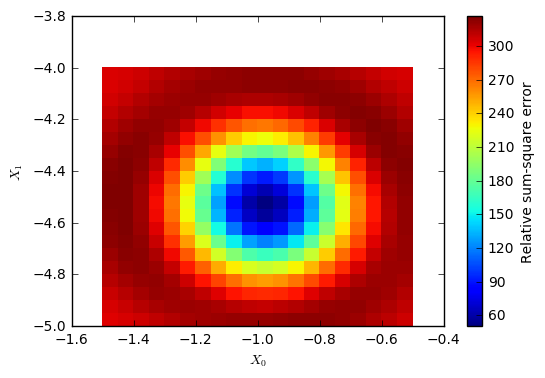

In [100]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(Xfine, -Yfine, Zfine / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$X_0$")
ax.set_ylabel("$X_1$")

plt.show()

In [103]:
# How well do we converge when we look in the right neighbourhood?
from skopt import gp_minimize
errors=[]
params_init = [(-.5+params_b[0],.5+params_b[0]),(-.5+params_b[1],.5+params_b[1])]
res = gp_minimize(model_err_minor_pos, params_init)

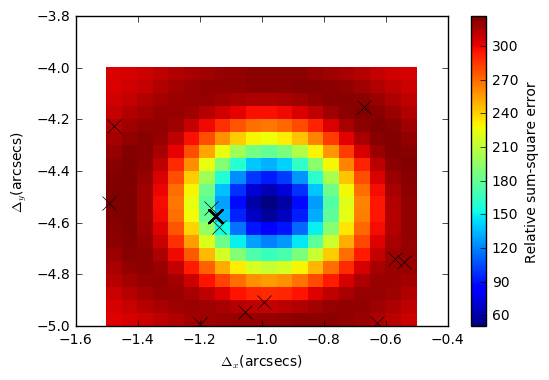

In [104]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cm = ax.pcolormesh(Xfine, -Yfine, Zfine / min_err)
cb = fig.colorbar(cm)
cb.set_label("Relative sum-square error")
ax.set_xlabel("$\Delta_x$(arcsecs)")
ax.set_ylabel("$\Delta_y$(arcsecs)")
tested = [(x,y) for ((_,_,_,x,y,_),e) in errors]
ax.plot([x for (x,y) in tested], [-y for (x,y) in tested],"kx", markersize=10)

plt.show()

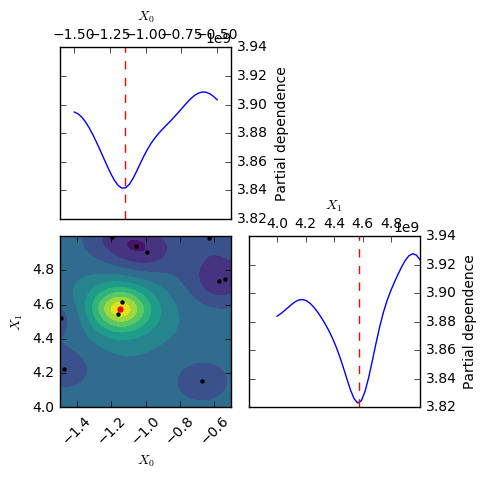

In [105]:
from skopt.plots import plot_objective

_ = plot_objective(res)
plt.show()